In [1]:
import os, sys
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import cv2
import time
import glob
import numpy as np
import random
import shutil
import itertools
import skimage.measure
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K

from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Input, Dense, Activation, Flatten, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, LeakyReLU
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import TensorBoard

from PIL import Image
from scipy import misc
from os import listdir
from os.path import isfile, join, splitext
from sklearn.metrics import f1_score
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
from collections import Counter
from IPython.display import display
from IPython.display import Image as _Imgdis

In [2]:
# Define variables:
batch_size = 32  
img_high   = 64
img_width  = 64

In [3]:
# Image processing. Basic manipulations: cropping, flipping and rotating.
    # Function to randomly crop the image and mask.
def randomCrop(image, mask, width, height):
    assert image.shape[0] >= height
    assert image.shape[1] >= width
    assert image.shape[0] == mask.shape[0]
    assert image.shape[1] == mask.shape[1]
    x = random.randint(0, image.shape[1] - width)
    y = random.randint(0, image.shape[0] - height)
    image = image[y:y+height, x:x+width]
    mask = mask[y:y+height, x:x+width]
    return image, mask

    # Function to randomly flip the image and mask, (horizontal flip).
def randomHorizontalFlip(image, mask, u=0.5):
    if np.random.random() < u:
        image = cv2.flip(image, 1)
        mask = cv2.flip(mask, 1)

    return image, mask

    # Function to randomly flip the image and mask, (vertical flip).
def randomVerticleFlip(image, mask, u=0.5):
    if np.random.random() < u:
        image = cv2.flip(image, 0)
        mask = cv2.flip(mask, 0)

    return image, mask

    # Function to randomly rotate the image and mask by 90 degrees.
def randomRotate90(image, mask, u=0.5):
    if np.random.random() < u:
        image=np.rot90(image)
        mask=np.rot90(mask)

    return image, mask


# Load dataset into train and valid sets.
    # The processing function for the training dataset.
def train_generator(batch_size):
    
    # Loading images from a directory.
    image_paths = sorted(glob.glob("train/X_img/*.jpg"))
    mask_paths  = sorted(glob.glob("train/y_msk/*.png"))

    assert len(image_paths) == len(mask_paths), "Must have mas for every image"

    while True:
        
        idxs = np.random.permutation(len(image_paths))
        
        for start_idx in range(0, len(image_paths), batch_size):
            if (start_idx + batch_size) >= len(image_paths): break
            
            x_train = []
            y_train = []
            for bidx in range(batch_size):
                idx = idxs[start_idx + bidx]
                
                src_img = misc.imread(image_paths[idx])
                src_msk = misc.imread(mask_paths[idx], cv2.IMREAD_GRAYSCALE)
                
                # Downsampling the satellite image and its mask by a factor of 2.
                pool = 2
                src_img = skimage.measure.block_reduce(src_img, (pool,pool,1), np.max) # Max_Pooling
                src_msk = skimage.measure.block_reduce(src_msk, (pool,pool,1), np.max) # Max_Pooling
                
                for attempt in reversed(list(range(100))):
                    
                    # Cropping the image and mask, (the chosen size is 64x64 resolution).
                    img, msk = randomCrop(src_img, src_msk, img_high, img_width)
                    
                    # Based on this criteria, the random crop windows are now discarded and resampled until at least 15% 
                    # of the pixels in an image are road pixels, (until 100 attempts). 
                    if (attempt > 0) and (np.sum((msk > 0).astype(np.float32)) / (img_high * img_width)) < 0.15: continue
                    
                    # Horizonta Flip
                    img, msk = randomHorizontalFlip(img, msk) 
                    # Verticle Flip
                    img, msk = randomVerticleFlip(img, msk) 
                    # Rotate
                    img, msk = randomRotate90(img, msk) 

                    # Normalising the dataset by dividing each image and mask by 255.
                    img = np.array(img, np.float32) / 255.0 
                    msk = (np.array(msk, np.float32) / 255.0) [:,:,0]

                    # Dividing the mask at threshold 0.5, because the mask image values might not be pure 0 and 1.
                    msk[msk>=0.5] = 1
                    msk[msk<=0.5] = 0

                    msk = np.expand_dims(msk, axis=2) 

                    x_train += [img]
                    y_train += [msk]
                    
                    break

            x_train = np.stack(x_train)
            y_train = np.stack(y_train)

            yield x_train, y_train
    
    # The processing function for the validation dataset.
def valid_generator(batch_size):
    
    # Loading images from a directory.
    image_paths = sorted(glob.glob("valid/X_img/*.jpg"))
    mask_paths  = sorted(glob.glob("valid/y_msk/*.png"))

    assert len(image_paths) == len(mask_paths), "Must have mas for every image"

    while True:
        idxs = np.random.permutation(len(image_paths))
        
        for start_idx in range(0, len(image_paths), batch_size):
            if (start_idx + batch_size) >= len(image_paths): break
            
            x_test = []
            y_test = []
            for bidx in range(batch_size):
                idx = idxs[start_idx + bidx]
            
                src_img = misc.imread(image_paths[idx])
                src_msk = misc.imread(mask_paths[idx], cv2.IMREAD_GRAYSCALE)
                
                # Downsampling the satellite image and its mask by a factor of 2.
                pool = 2
                src_img = skimage.measure.block_reduce(src_img, (pool,pool,1), np.max) # Max_Pooling
                src_msk = skimage.measure.block_reduce(src_msk, (pool,pool,1), np.max) # Max_Pooling
                
                for attempt in reversed(list(range(100))):
                    
                    # Cropping the image and mask, (the chosen size is 64x64 resolution).
                    img, msk = randomCrop(src_img, src_msk, img_high, img_width) 

                    # Based on this criteria, the random crop windows are now discarded and resampled until at least 15% 
                    # of the pixels in an image are road pixels, (until 100 attempts). 
                    if (attempt > 0) and (np.sum((msk > 0).astype(np.float32)) / (img_high * img_width)) < 0.15: continue

                    # Normalising the dataset by dividing each image and mask by 255.
                    img = np.array(img, np.float32) / 255.0 
                    msk = (np.array(msk, np.float32) / 255.0) [:,:,0]

                    # Dividing the mask at threshold 0.5, because the mask image values might not be pure 0 and 1.
                    msk[msk>=0.5] = 1
                    msk[msk<=0.5] = 0

                    msk = np.expand_dims(msk, axis=2)

                    x_test += [img]
                    y_test += [msk]
                    
                    break

            x_test = np.stack(x_test)
            y_test = np.stack(y_test)

            yield x_test, y_test

/usr/lib/python3/dist-packages/ipykernel_launcher.py:133: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:134: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


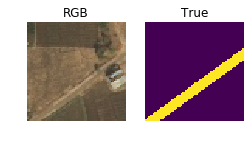

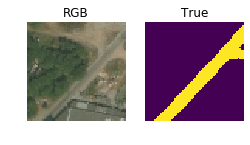

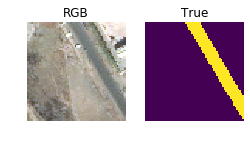

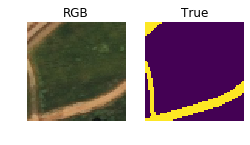

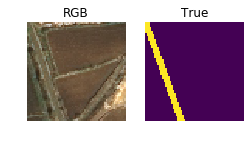

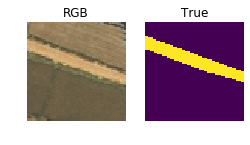

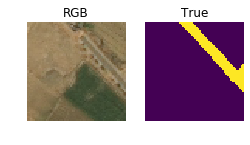

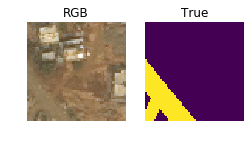

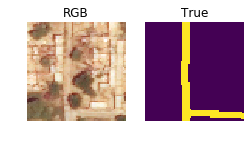

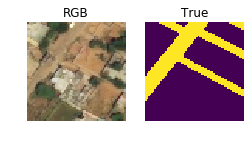

In [4]:
# Plotting images to see the result of processing function (here for the validation dataset).
v_gen = valid_generator(1)

for _ in range(10):
    
    x,y = next(v_gen)

    plt.subplot(1,3,1)
    plt.grid(False)
    plt.axis('off')
    plt.title('RGB')
    plt.imshow(x[0].reshape(img_high, img_width, 3)) # image

    plt.subplot(1,3,2)
    plt.grid(False)
    plt.axis('off')
    plt.title('True')
    plt.imshow(y[0].reshape(img_high, img_width)) # true label

    plt.show()

In [5]:
# Jaccard Index, also known as Intersection over Union (IOU)
def IoU(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred) # K.round(y_pred)
    
    intersection = y_true * y_pred
    notTrue      = 1. - y_true
    union        = y_true + (notTrue * y_pred)

    return K.sum(intersection) / K.sum(union)

# A slightly modified version of IoU metric, (this metric rounds predictions before computing IoU).
def discrete_IoU(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(K.round(y_pred))
    
    intersection = y_true * y_pred
    notTrue      = 1. - y_true
    union        = y_true + (notTrue * y_pred)

    return K.sum(intersection) / K.sum(union)

# Define the model architecture
leaky_relu = lambda x : LeakyReLU(0.1)(x)

inputs = Input(shape=(None,None,3))

x = Conv2D(64, (3, 3), padding='same', activation=leaky_relu, input_shape=(img_high, img_width, 3))(inputs)
x = Conv2D(64, (3, 3), padding='same', activation=leaky_relu)(x)

x = Conv2D(64, (3, 3), padding='same', activation=leaky_relu)(x)
x = Conv2D(64, (3, 3), padding='same', activation=leaky_relu)(x)

x = Conv2D(64, (3, 3), padding='same', activation=leaky_relu)(x)
x = Conv2D(64, (3, 3), padding='same', activation=leaky_relu)(x)

x = Conv2D(64, (3, 3), padding='same', activation=leaky_relu)(x)
x = Conv2D(64, (3, 3), padding='same', activation=leaky_relu)(x)

output = Conv2D(1, (1, 1), padding='same', activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=[output])
print(model.summary())

# Compile model
model.compile(loss=['binary_crossentropy'], optimizer='adam', metrics=['binary_accuracy', IoU, discrete_IoU])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
conv2d (Conv2D)              (None, None, None, 64)    1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 64)    36928     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 64)    36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, None, 64)    36928     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, None, None, 64)    36928     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, None, None, 64)    36928     
__________

In [6]:
# Fit model on training data
epoch_steps = len([f for f in listdir('train/X_img')]) // batch_size
valid_steps = len([f for f in listdir('valid/X_img')]) // batch_size

t_gen = train_generator(batch_size)
v_gen = valid_generator(batch_size)

log_dir = './logs/gpu_64f_resample_64p_downsampled/'

tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=1, 
                          write_graph=True, write_images=False)

checkpointer = ModelCheckpoint(log_dir+'weights - epoch {epoch:06d}.h5', save_weights_only=True)

epochs = 100

is_train = False

if (is_train):
    history = model.fit_generator(t_gen,
            steps_per_epoch = epoch_steps+1, 
            epochs = epochs,
            verbose=1,
            validation_data = v_gen,
            validation_steps= valid_steps+1,                             
            callbacks=[tensorboard, checkpointer])

    # Save the weights of a model     
    model.save_weights(log_dir+'weights.h5')
    print("Saved model to disk")


In [7]:
# Load the weights of a model
model.load_weights(log_dir+'model - epoch 000085.h5')

/usr/lib/python3/dist-packages/ipykernel_launcher.py:133: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:134: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


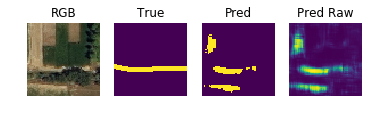

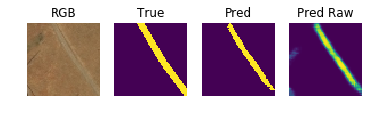

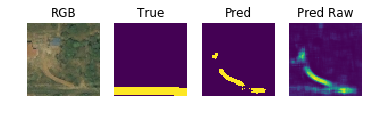

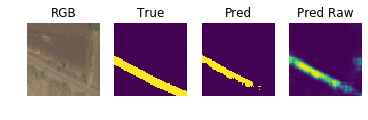

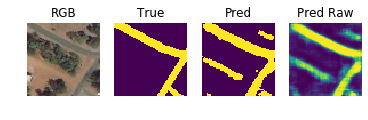

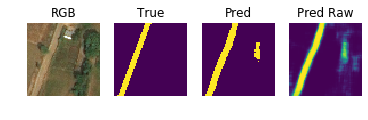

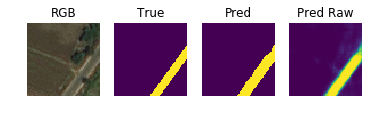

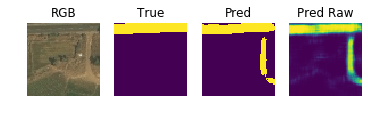

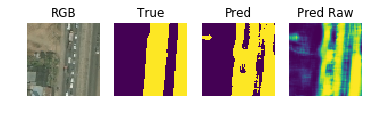

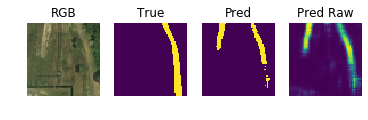

In [8]:
# Plot 10 samples of the satellite images followed by 
# their ground truth masks, the predicted threshold maps and the predicted raw maps.
for _ in range(10):
    
    x,y = next(v_gen)
    y_hat = model.predict(x, verbose=0)

    plt.subplot(1,4,1)
    plt.axis('off')
    plt.title('RGB')
    plt.imshow(x[0].reshape(img_high, img_width, 3)) # image

    plt.subplot(1,4,2)
    plt.axis('off')
    plt.title('True')
    plt.imshow(y[0].reshape(img_high, img_width)) # true label

    plt.subplot(1,4,3)
    plt.axis('off')
    plt.title('Pred')
    plt.imshow(y_hat[0].reshape(img_high, img_width) > 0.5) # predicted label, (Confident values).
    
    plt.subplot(1,4,4)
    plt.axis('off')
    plt.title('Pred Raw')
    plt.imshow(y_hat[0].reshape(img_high, img_width)) # predicted label, (raw map values).

    plt.show()

/usr/lib/python3/dist-packages/ipykernel_launcher.py:133: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:134: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


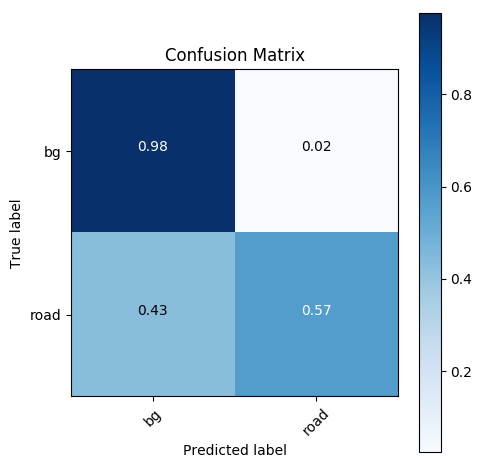

In [9]:
# Creating the Confusion Matrix

y_tests = []
y_preds = []

for step in range(32):
    print('eval step:', step, end='\r')
    x_test, y_test = next(v_gen)
    y_pred = np.round(model.predict(x_test))

    y_tests += [y_test]
    y_preds += [y_pred]
    
y_test = np.reshape(np.concatenate(y_test, axis=0), (-1,))
y_pred = np.reshape(np.concatenate(y_pred, axis=0), (-1,))

y_test = y_test.astype(np.int32)
y_pred = y_pred.astype(np.int32)

cm = confusion_matrix(y_test.tolist(), y_pred.tolist())

def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion Matrix', cmap=plt.cm.get_cmap('Blues')):
    
    figw=500 
    figh=500 
    figdpi=100
    fig = plt.figure(facecolor='white', figsize=(figw/figdpi, figh/figdpi), dpi=figdpi)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                     color="white" if (cm[i, j] > thresh) else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(cm, ['bg','road'])